In [1]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
import featuretools as ft

from sklearn.metrics import make_scorer, mean_absolute_error, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

from sklearn.pipeline import make_union
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate

from category_encoders import OrdinalEncoder, OneHotEncoder, CountEncoder

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from pathlib import Path
import config

sys.path.append('./starspace36_mono_model')
# import starspace_resources as sw_resources

pd.set_option('display.max_rows', 120)
plt.style.use("dark_background")
plt.rcParams['figure.figsize'] = (20, 15)

print(Path.cwd())

/home/flu/flu_vaccine_challenge/drivendata_flu_shot


In [2]:
X = pd.read_csv("./input/training_set_features.csv", index_col='respondent_id')
y = pd.read_csv("./input/training_set_labels.csv", index_col='respondent_id')
submission_format = pd.read_csv("./input/submission_format.csv", index_col='respondent_id')
test_set = pd.read_csv("./input/test_set_features.csv", index_col='respondent_id')

In [3]:
# X.replace(to_replace=config.ordinal_to_replace, inplace=True)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3)



In [4]:
X['test'] = False
test_set['test'] = True

X.reset_index(inplace=True, )
test_set.reset_index(inplace=True, )
X_joined = X.append(test_set, ignore_index=True, sort=False)

In [5]:
# split for ordinal values manually, i.e. ages groups
X_joined.replace(to_replace=config.ordinal_to_replace, inplace=True)

numeric = []
for col in config.ordinal:
    num_col = f'{col}_num'
    numeric.append(num_col)
    X_joined[num_col] = X_joined[col]

In [6]:
# Add dataframe to entityset
categorical_ft = dict([col, ft.variable_types.Boolean] for col in config.categorical.keys())
ordinal_ft = dict([col, ft.variable_types.Ordinal] for col in config.ordinal)
numeric_ft = dict([col, ft.variable_types.Numeric] for col in numeric)
variable_dtypes = {**categorical_ft, **ordinal_ft, **numeric_ft}

In [7]:
# Create an entity set
es = ft.EntitySet(id='flu')
es = es.entity_from_dataframe(entity_id='flu',
                              dataframe=X_joined,
                              index='respondent_id',
                              variable_types=variable_dtypes,
                              )

In [8]:
es['flu']

Entity: flu
  Variables:
    respondent_id (dtype: index)
    test (dtype: boolean)
    behavioral_antiviral_meds (dtype: boolean)
    behavioral_avoidance (dtype: boolean)
    behavioral_face_mask (dtype: boolean)
    behavioral_wash_hands (dtype: boolean)
    behavioral_large_gatherings (dtype: boolean)
    behavioral_outside_home (dtype: boolean)
    behavioral_touch_face (dtype: boolean)
    doctor_recc_h1n1 (dtype: boolean)
    doctor_recc_seasonal (dtype: boolean)
    chronic_med_condition (dtype: boolean)
    child_under_6_months (dtype: boolean)
    health_worker (dtype: boolean)
    health_insurance (dtype: boolean)
    race (dtype: boolean)
    sex (dtype: boolean)
    marital_status (dtype: boolean)
    rent_or_own (dtype: boolean)
    employment_status (dtype: boolean)
    hhs_geo_region (dtype: boolean)
    census_msa (dtype: boolean)
    employment_industry (dtype: boolean)
    employment_occupation (dtype: boolean)
    h1n1_concern (dtype: ordinal)
    h1n1_knowledge (dt

In [9]:
ft.list_primitives()

,name,type,dask_compatible,koalas_compatible,description
0,min,aggregation,True,True,"Calculates the smallest value, ignoring `NaN` ..."
1,time_since_last,aggregation,False,False,Calculates the time elapsed since the last dat...
2,mean,aggregation,True,True,Computes the average for a list of values.
3,any,aggregation,True,False,Determines if any value is 'True' in a list.
4,percent_true,aggregation,True,False,Determines the percent of `True` values.
5,first,aggregation,False,False,Determines the first value in a list.
6,skew,aggregation,False,False,Computes the extent to which a distribution di...
7,sum,aggregation,True,True,"Calculates the total addition, ignoring `NaN`."
8,avg_time_between,aggregation,False,False,Computes the average number of seconds between...
9,num_true,aggregation,True,False,Counts the number of `True` values.


In [10]:
# Define which primitives to use
#agg_primitives =  ['count',]
# trans_primitives = ['cum_sum']

agg_primitives =  ['count', 'mean', 'num_unique']
trans_primitives = ['add_numeric']

In [11]:
# Run deep feature synthesis
dfs_feat, dfs_defs = ft.dfs(entityset=es,
                            target_entity='flu',
                            trans_primitives=trans_primitives,
                            agg_primitives=agg_primitives,
                            max_features=1000,
                            chunk_size=4000,
                            verbose=True,
                            max_depth=2,
                            n_jobs=1)


Built 127 features
Elapsed: 00:00 | Progress:   0%|          

/home/flu/anaconda3/lib/python3.7/site-packages/featuretools/synthesis/dfs.py:317: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['count', 'mean', 'num_unique']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


Elapsed: 00:00 | Progress: 100%|██████████


In [12]:
dfs_feat.shape

(53415, 127)

In [13]:
test_set = dfs_feat.loc[dfs_feat.test].copy()
test_set.drop(columns=['test'], inplace=True)
test_set = test_set.astype(config.categorical)

In [14]:
X_hyper = dfs_feat.loc[~dfs_feat.test].copy()
X_hyper = X_hyper.astype(config.categorical)
X_hyper.drop(columns=['test'], inplace=True)

In [15]:
del X, dfs_feat, dfs_defs


In [16]:
def hyperopt_ctb_scoreCV_manual(params):
    
    global X_hyper
    global y_hyper
    global global_best_model

    for key in catboost_space:
        print(f'       {key} {params[key]}')
    
    clf = CatBoostClassifier(**params)
    skf = StratifiedKFold(n_splits=3)
    
    cross_val_result = {'estimator': [], 'test_score': []}
    for i, (train_ind, val_ind) in enumerate(skf.split(X_hyper, y_hyper)):
        
        train_set = Pool(data=X_hyper.loc[train_ind], label=y_hyper[train_ind], cat_features=config.categorical.keys())
        val_set = Pool(data=X_hyper.loc[val_ind], label=y_hyper[val_ind], cat_features=config.categorical.keys())
        
        clf.fit(X=train_set, eval_set=val_set, use_best_model=True)
        cross_val_result['estimator'].append(clf)
        cross_val_result['test_score'].append(clf.get_best_score()['validation']['AUC'])
    

    # current_score = clf.get_best_score()['validation']['AUC']
    current_score = np.mean(cross_val_result['test_score'])

    if current_score > global_best_model['AUC']:
        global_best_model['AUC'] = current_score
        global_best_model['model'] = cross_val_result['estimator']
        print(f'new best AUC = {current_score}')

    result = {
        'loss': -current_score,
        'status': STATUS_OK,

        # -- store other results like this
        'eval_time': time.time(),
        'other_stuff': {'type': None, 'value': [0, 1, 2]},
        # 'model': clf,
        # -- attachments are handled differently
        'attachments':
            {'attachments': 'attachments'}
    }
        
    return result

In [17]:
catboost_space = {

    # 'grow_policy': hp.choice('grow_policy', ['Lossguide', 'Depthwise']), # 'SymmetricTree',  #  'Depthwise',
    # 'auto_class_weights': hp.choice('auto_class_weights', ['SqrtBalanced','Balanced']),
    # 'langevin': True,  # CPU only
    # 'learning_rate': hp.quniform('learning_rate', 1e-3, 3e-2, 1e-3),
    'depth':  hp.choice('depth', np.arange(5, 14, dtype=int)),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 300, 1),
    'max_leaves': hp.choice('max_leaves', np.arange(5, 64, dtype=int)),  
    'border_count': hp.choice('border_count', np.arange(64, 256, dtype=int)), 

    'random_strength': hp.quniform('random_strength', 1e-3, 8e-1, 1e-3), 
    'bagging_temperature': hp.quniform('bagging_temperature', 1e-3, 8e-1, 1e-3), 
}

In [18]:
%%time 

# Hyperopt main loop
models = {}
for col in y.columns:
    print('********* Hyperopt main loop', col, '*****************')
    
    global_best_model = {'AUC': -1, 'model': None}
    
    y_hyper = y[col]
    
#     train_set = Pool(data=X_train, label=y_train[col], cat_features=X_train.columns)
#     val_set = Pool(data=X_test, label=y_test[col], cat_features=X_test.columns)

    hyperopt_local_params = config.params.copy()
    hyperopt_local_params.update(catboost_space)

    # trials = Trials()
    # best = fmin(fn=hyperopt_ctb_score, space=hyperopt_local_params, algo=tpe.suggest, max_evals=100, trials=trials, verbose=False)
    best = fmin(fn=hyperopt_ctb_scoreCV_manual, 
                space=hyperopt_local_params, 
                algo=tpe.suggest, 
                max_evals=30,
                verbose=True,
               )

    models[col] = global_best_model
    
#     hyperopt_local_params.update(best)
#     hyper_best_params[col] = hyperopt_local_params

********* Hyperopt main loop h1n1_vaccine *****************
       depth 9                                        
       l2_leaf_reg 219.0                              
       max_leaves 8                                   
       border_count 254                               
       random_strength 0.48                           
       bagging_temperature 0.022                      
0:	learn: 0.7506243	test: 0.7518720	best: 0.7518720 (0)	total: 76.4ms	remaining: 25m 28s

1000:	learn: 0.8556562	test: 0.8534957	best: 0.8534957 (1000)	total: 17.8s	remaining: 5m 38s

2000:	learn: 0.8670512	test: 0.8620171	best: 0.8620171 (2000)	total: 36.9s	remaining: 5m 31s

3000:	learn: 0.8722885	test: 0.8662491	best: 0.8662491 (3000)	total: 56s	remaining: 5m 17s

4000:	learn: 0.8755545	test: 0.8683046	best: 0.8683046 (4000)	total: 1m 15s	remaining: 5m

5000:	learn: 0.8779495	test: 0.8694466	best: 0.8694466 (5000)	total: 1m 34s	remaining: 4m 42s

6000:	learn: 0.8796432	test: 0.8702128	best: 0.8702139

h1n1_vaccine
{'AUC': 0.872631881555915, 'model': [<catboost.core.CatBoostClassifier object at 0x7f1e674597d0>, <catboost.core.CatBoostClassifier object at 0x7f1e674597d0>, <catboost.core.CatBoostClassifier object at 0x7f1e674597d0>]}
<class 'catboost.core.CatBoostClassifier'> <catboost.core.CatBoostClassifier object at 0x7f1e674597d0>
seasonal_vaccine
{'AUC': 0.8640446549314014, 'model': [<catboost.core.CatBoostClassifier object at 0x7f1e62bc8a10>, <catboost.core.CatBoostClassifier object at 0x7f1e62bc8a10>, <catboost.core.CatBoostClassifier object at 0x7f1e62bc8a10>]}
<class 'catboost.core.CatBoostClassifier'> <catboost.core.CatBoostClassifier object at 0x7f1e62bc8a10>


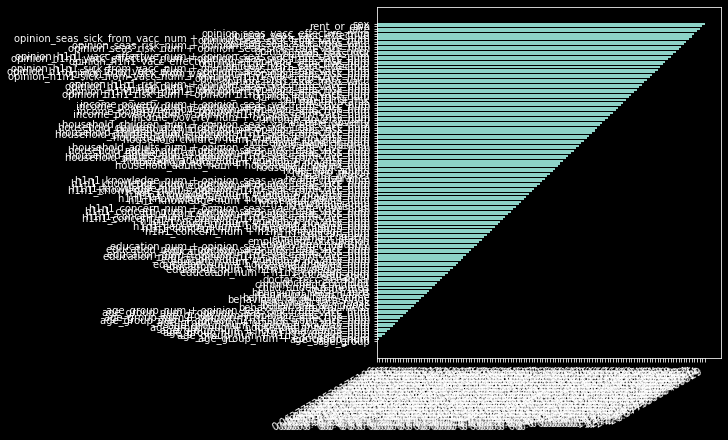

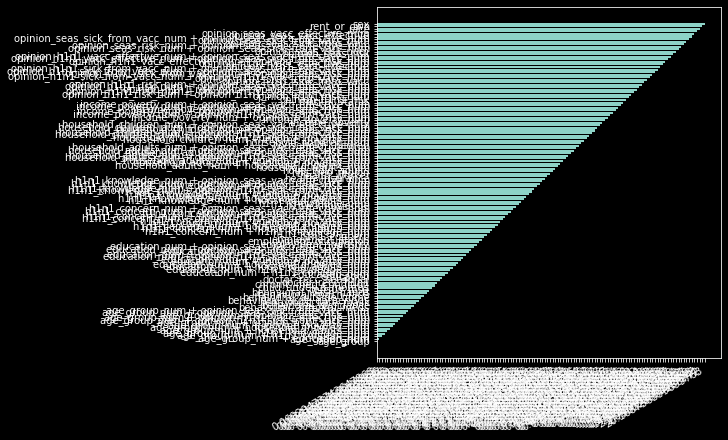

In [19]:
# Графики feature importances

for model_name, best_model_dict in models.items():
    print(model_name)
    print(best_model_dict)
    model = best_model_dict['model'][0]
    print(type(model), model)
    for feature_name, feature_importance in zip(model.feature_names_, model.feature_importances_):
        if feature_importance < 0.01:
            print( feature_name, feature_importance)

    importances_np = np.sort(np.array([model.feature_importances_, model.feature_names_]), axis=1)

    fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True);
    ax.barh(importances_np[1], importances_np[0], align='center');
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right");


In [20]:
print("submission")

submission_df = pd.DataFrame(index=test_set.index)
for i, (col, best_model_dict) in enumerate(models.items()):
    test_pool = Pool(test_set, cat_features=config.categorical.keys())

    predictions_df = pd.DataFrame(index=test_set.index)
    for model in best_model_dict['model']:
        predictions_df[i] = model.predict_proba(test_pool)[:, 1]
            
        
    submission_df[col] = predictions_df.mean(axis=1)

print("submission_df.shape", submission_df.shape)
print(submission_df.head())

submission
submission_df.shape (26708, 2)
               h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707              0.117993          0.220481
26708              0.047773          0.053162
26709              0.209030          0.815453
26710              0.778078          0.937639
26711              0.455865          0.671163


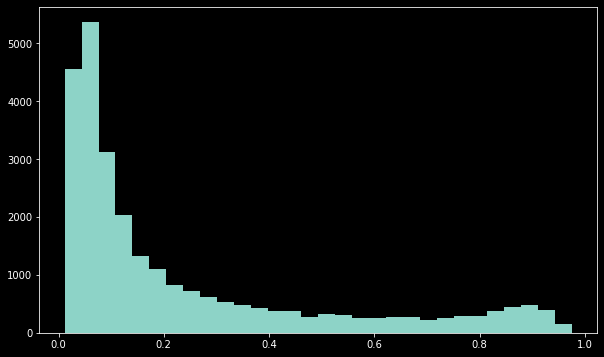

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(submission_df.h1n1_vaccine, bins=30);

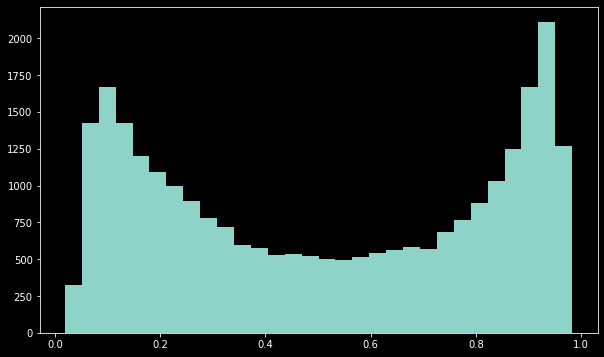

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(submission_df.seasonal_vaccine, bins=30);

In [23]:
submission_df.to_csv("./flu_submission_ycloud.csv")

In [24]:
print('*********   FINISH  ************')




*********   FINISH  ************
